In [71]:
import os
import numpy as np
import sys
import time

from amd.rocal.pipeline import Pipeline
import amd.rocal.fn as fn
import amd.rocal.types as types

In [72]:
batch_size=2
sequence_length=3
video_directory=os.path.join(os.environ['ROCAL_DATA_PATH'], "video_and_sequence_samples", "labelled_videos")
num_threads=4
shuffle=True
rocal_cpu=True
device_id=0
random_seed=1
n_iter=6

In [74]:
pipe = Pipeline(batch_size=batch_size, num_threads=num_threads, device_id=device_id, seed=random_seed, rocal_cpu=rocal_cpu)
with pipe:
    images = fn.readers.video(device="gpu", file_root=video_directory, sequence_length=sequence_length,
                          normalized=False, random_shuffle=shuffle, image_type=types.RGB,
                          dtype=types.FLOAT, initial_fill=16, pad_last_batch=True, name="Reader", step=step, stride=1)
    pipe.set_outputs(images)

Pipeline has been created succesfully
OK: loaded 80 kernels from libvx_rpp.so


In [75]:
pipe.build()

In [76]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [77]:
def display_sequence(sequence):
    w = sequence.shape[1]
    h = sequence.shape[0] // sequence_length
    c = sequence.shape[2]
    columns = 3
    rows = (sequence_length + 1) // (columns)
    fig = plt.figure(figsize = (32,(16 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        x = h * j
        img = sequence[x:x+720 ,:,:] #((sequence + (w * h * c)) * 255).astype(np.uint8)
        plt.imshow(img)
    plt.close(fig)

In [49]:
class ROCALVideoIterator(object):
    """
    ROCALVideoIterator.

    Parameters
    ----------
    pipelines : list of amd.rocal.pipeline.Pipeline
                List of pipelines to use
    size : int
           Epoch size.
    """

    def __init__(self, pipelines, tensor_layout=types.NCHW, reverse_channels=False, multiplier=None, offset=None, tensor_dtype=types.FLOAT, display=False ,sequence_length=3):

        try:
            assert pipelines is not None, "Number of provided pipelines has to be at least 1"
        except Exception as ex:
            print(ex)

        self.loader = pipelines
        self.tensor_format = tensor_layout
        self.multiplier = multiplier if multiplier else [1.0, 1.0, 1.0]
        self.offset = offset if offset else [0.0, 0.0, 0.0]
        self.reverse_channels = reverse_channels
        self.tensor_dtype = tensor_dtype
        self.batch_size = self.loader._batch_size
        self.w = self.loader.getOutputWidth()
        self.h = self.loader.getOutputHeight()
        self.n = self.loader.getOutputImageCount()
        self.rim = self.loader.getRemainingImages()
        self.display = display
        self.iter_num = 0
        self.sequence_length = sequence_length
        print("____________REMAINING IMAGES____________:", self.rim)
        color_format = self.loader.getOutputColorFormat()
        self.p = (1 if color_format is types.GRAY else 3)
        self.out = np.empty(
                (self.batch_size*self.n,int(self.h/self.batch_size), self.w,self.p), dtype="ubyte")

    def next(self):
        return self.__next__()

    def __next__(self):
        self.iter_num +=1
        if(self.loader.isEmpty()):
            raise StopIteration
        if self.loader.run() != 0:
            raise StopIteration
        #Copy output from buffer to numpy array
        self.loader.copyImage(self.out)
        return self.out

    def reset(self):
        self.loader.rocalResetLoaders()

    def __iter__(self):
        return self

____________REMAINING IMAGES____________: 12


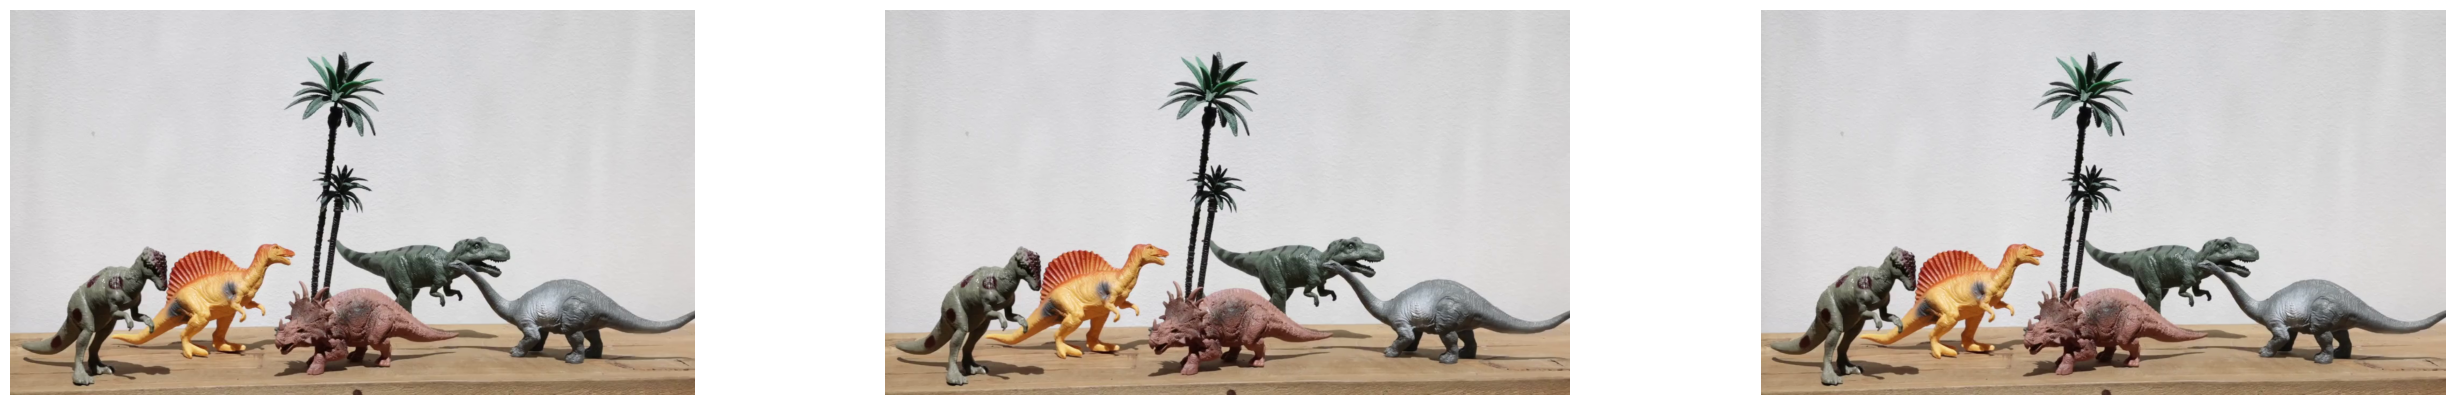

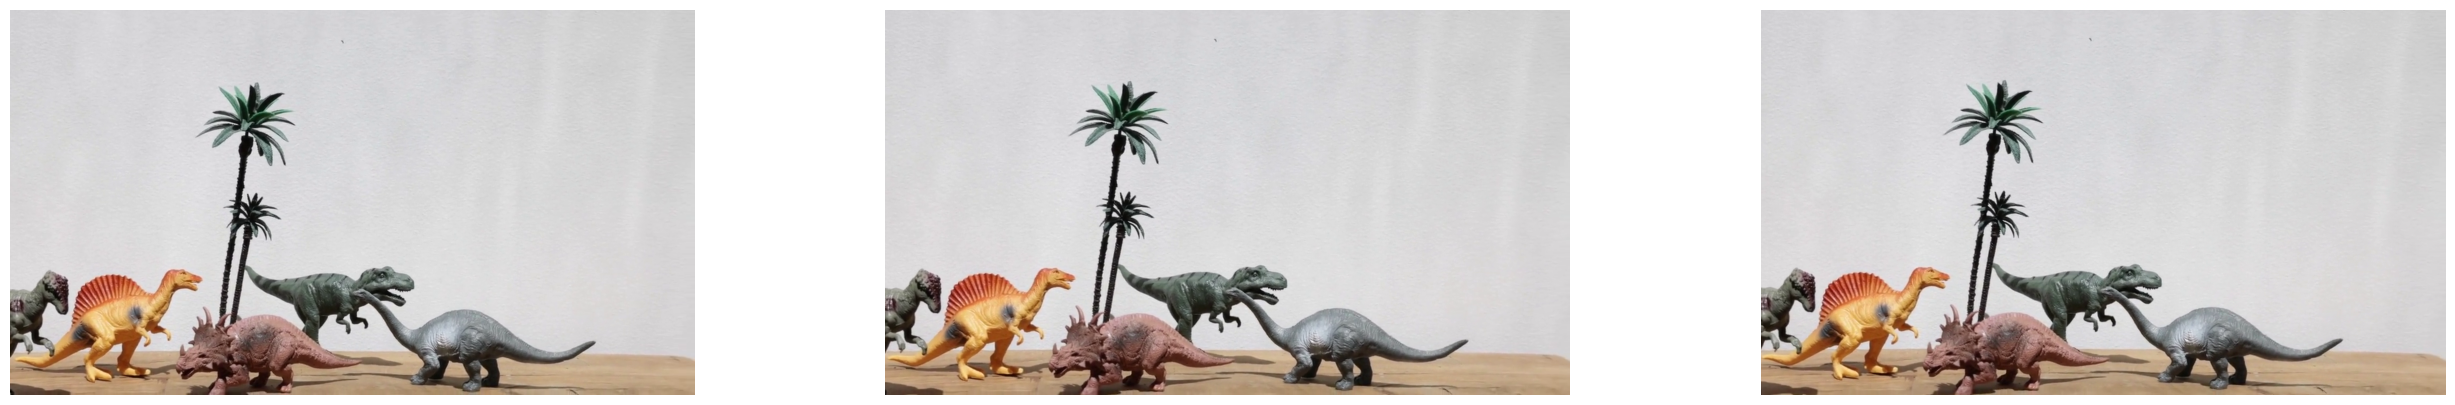

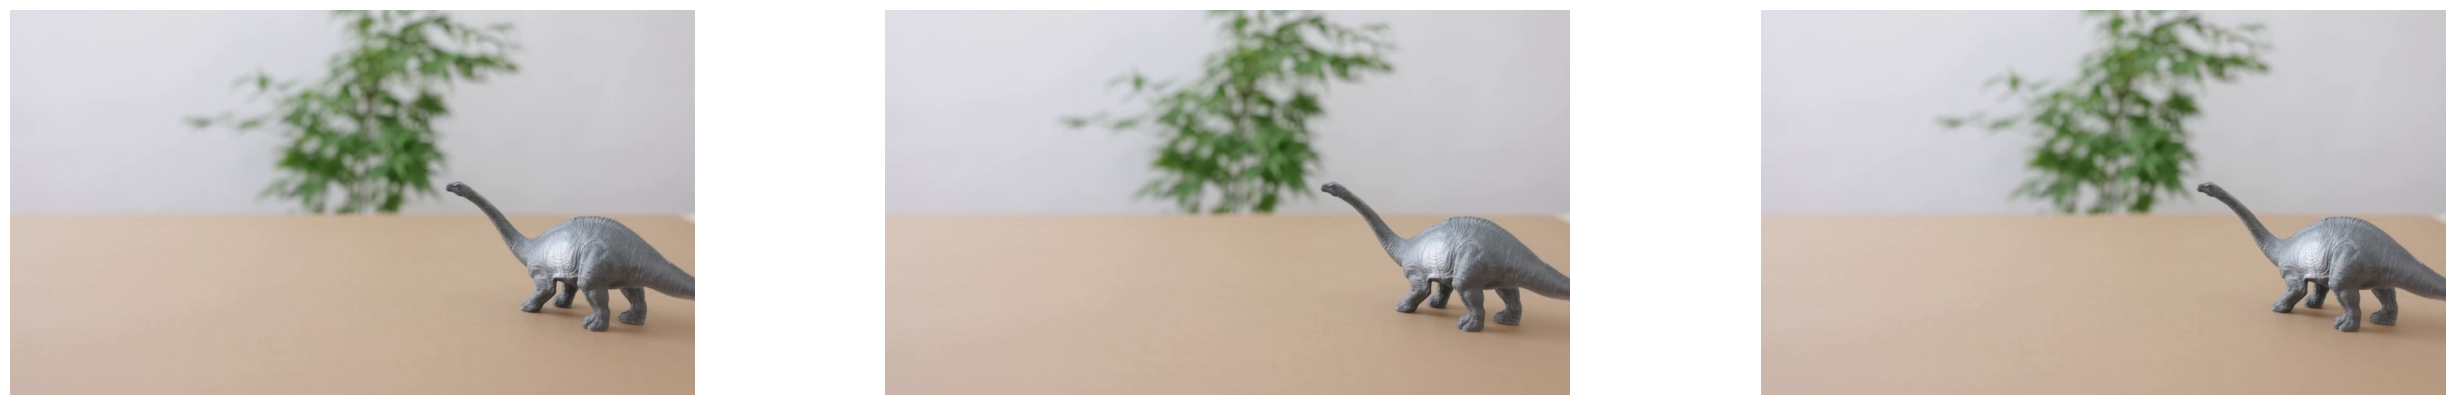

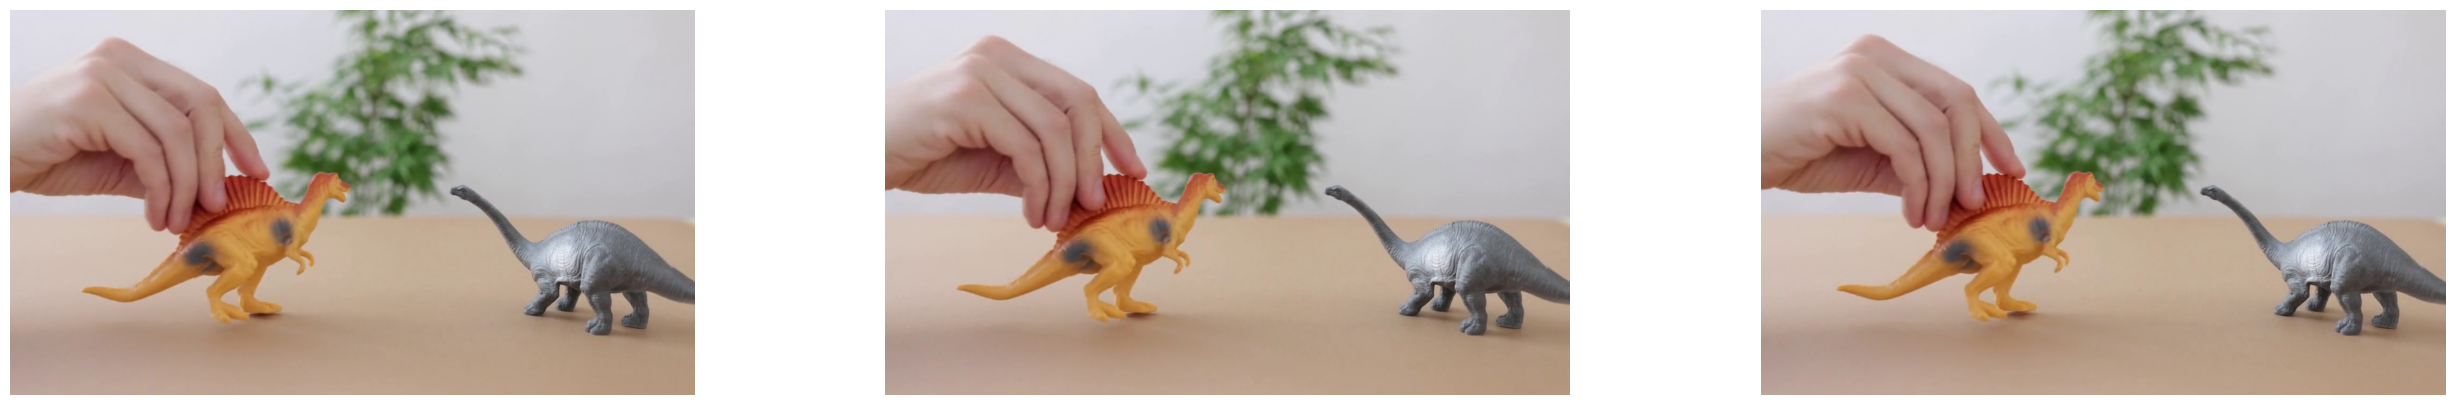

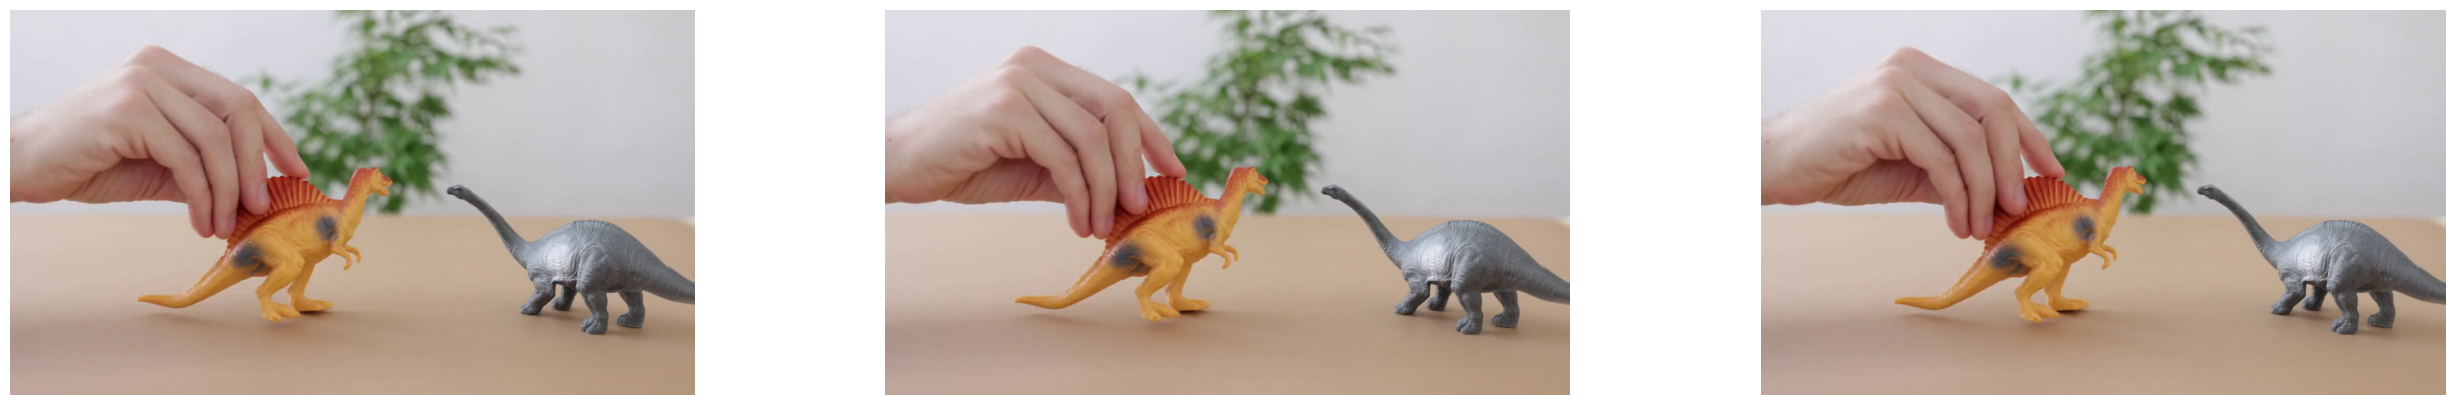

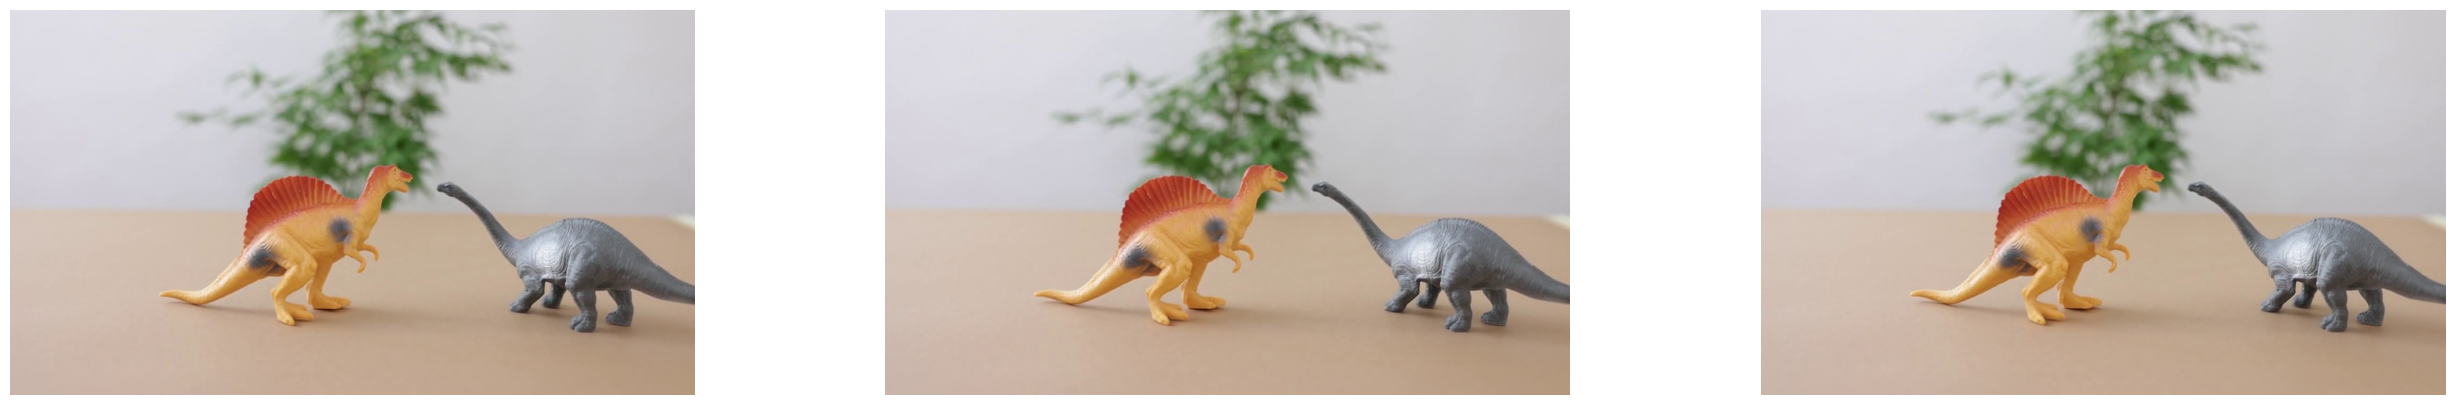

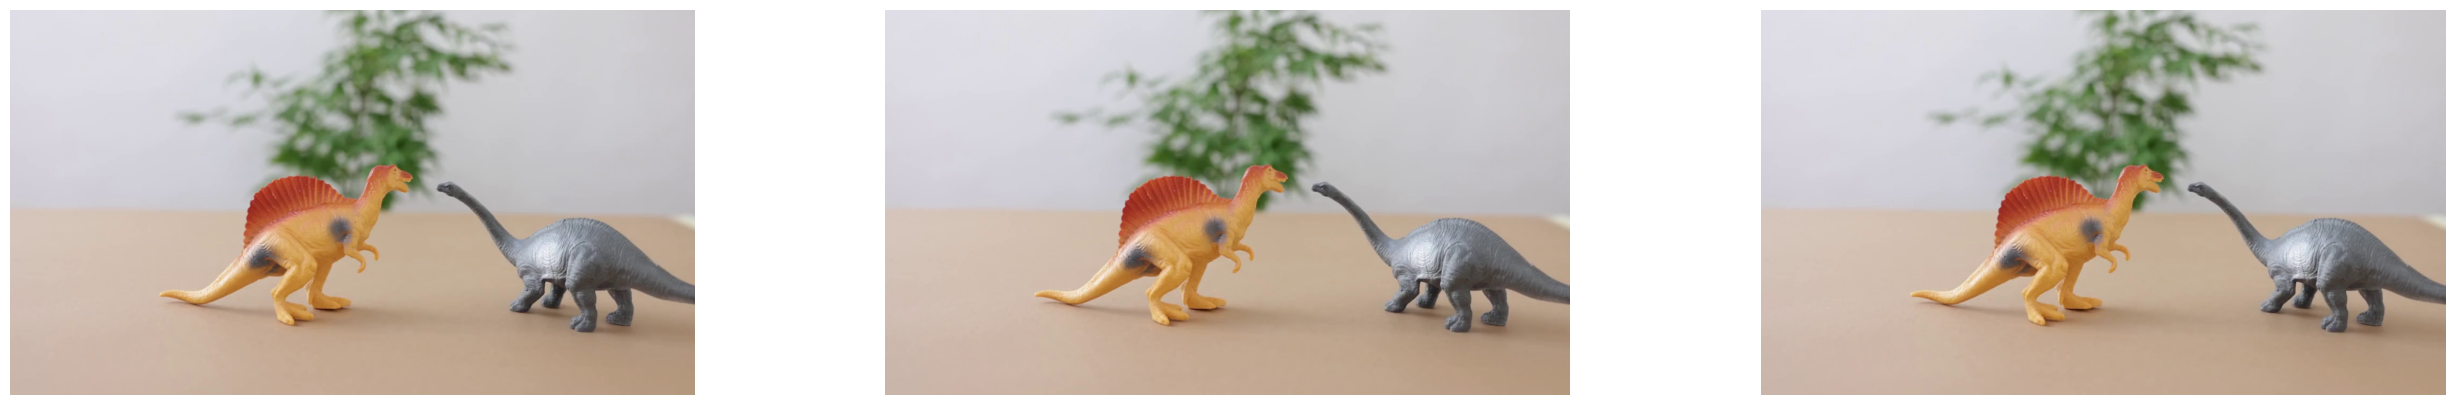

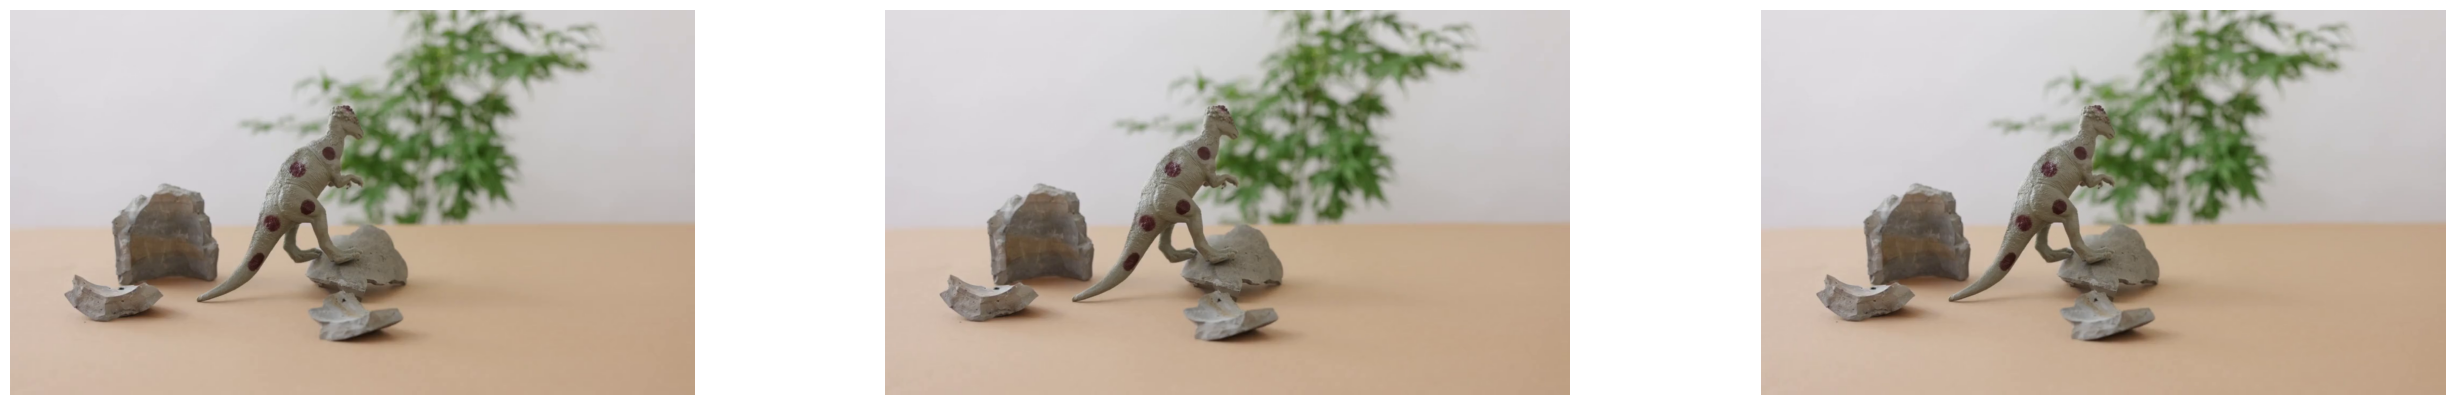

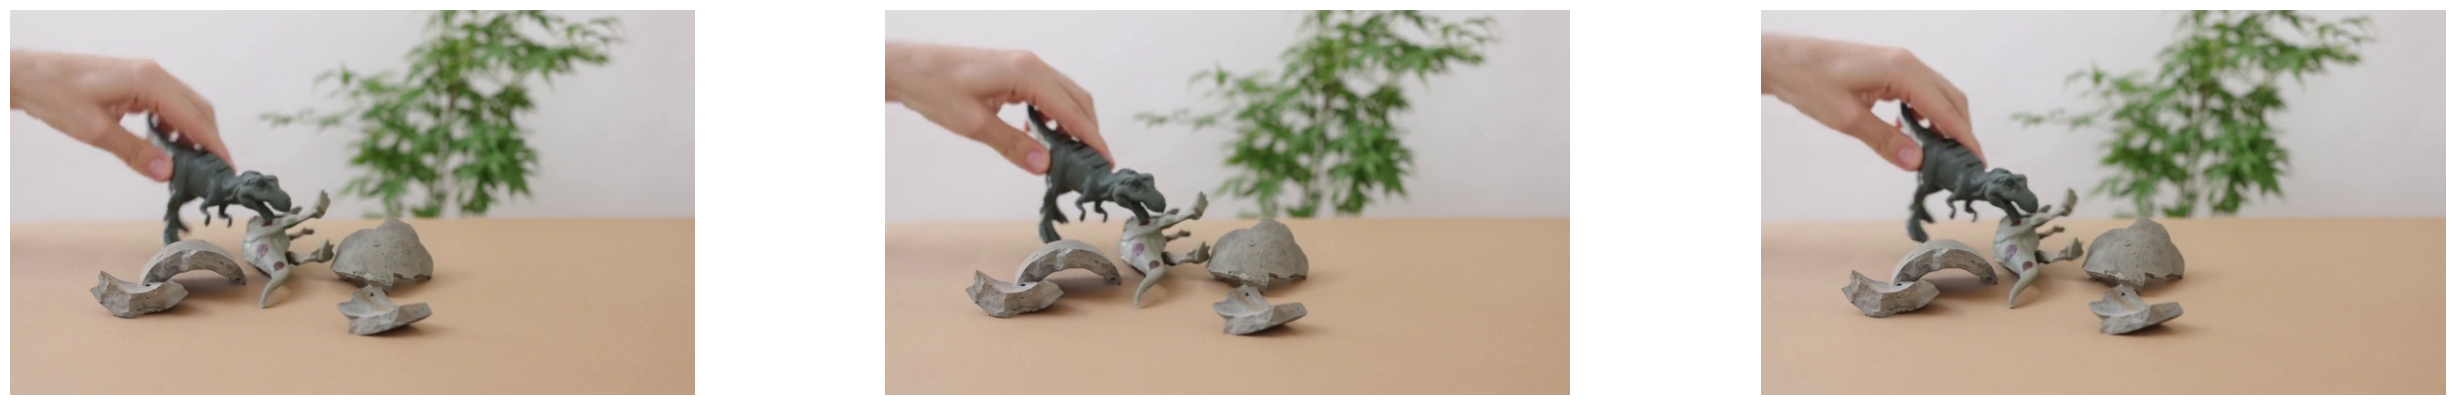

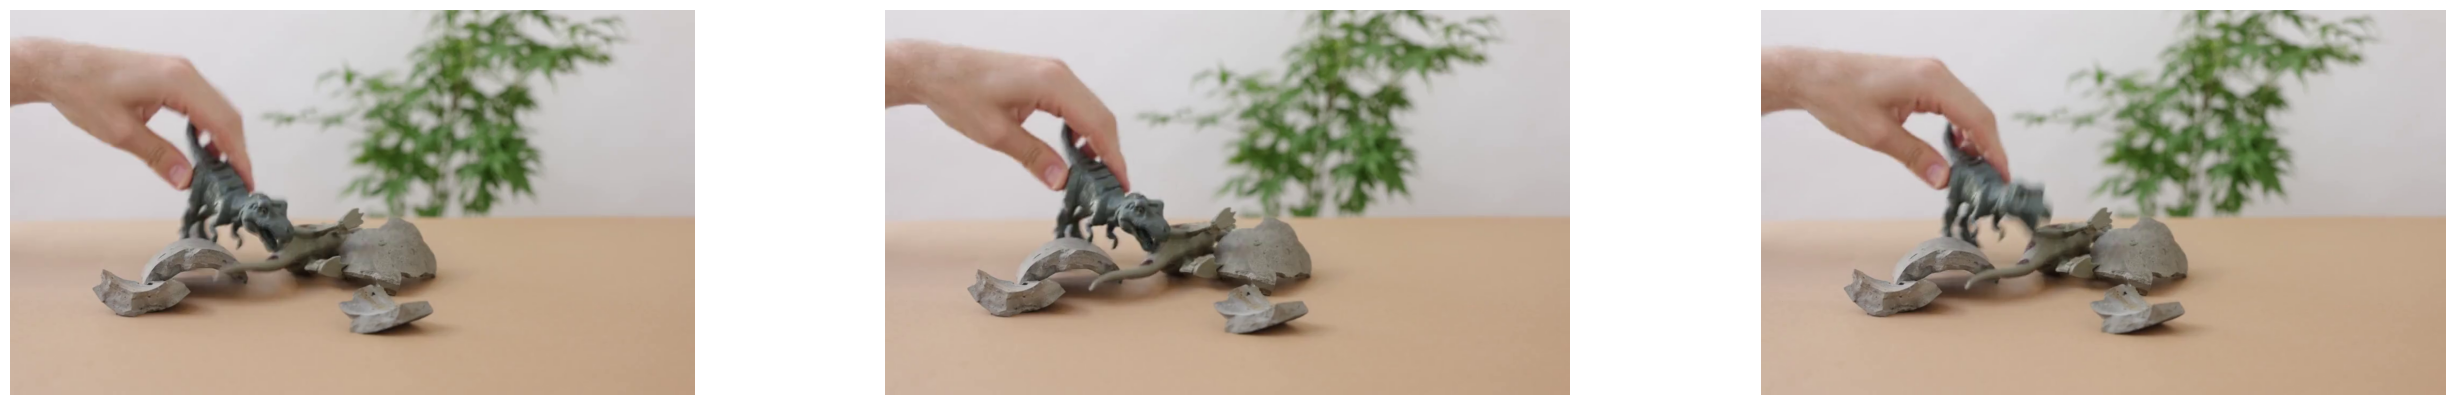

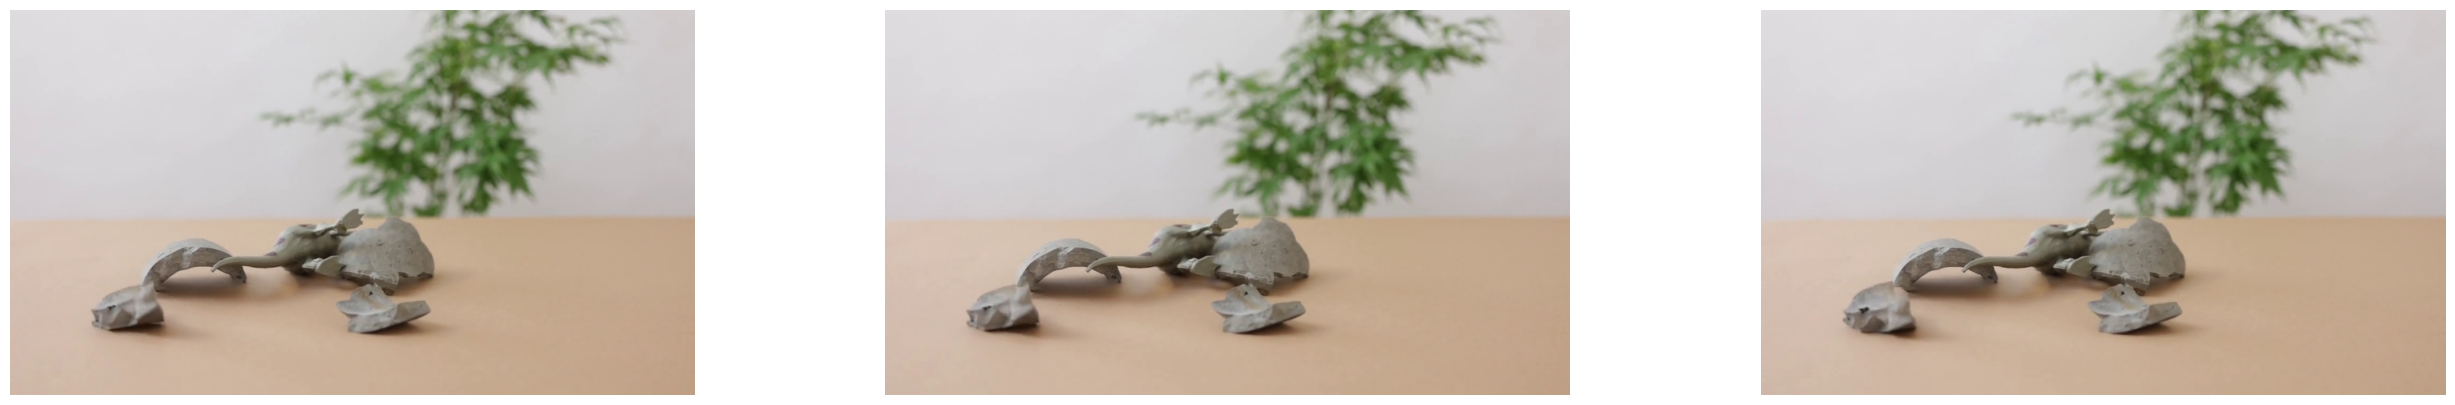

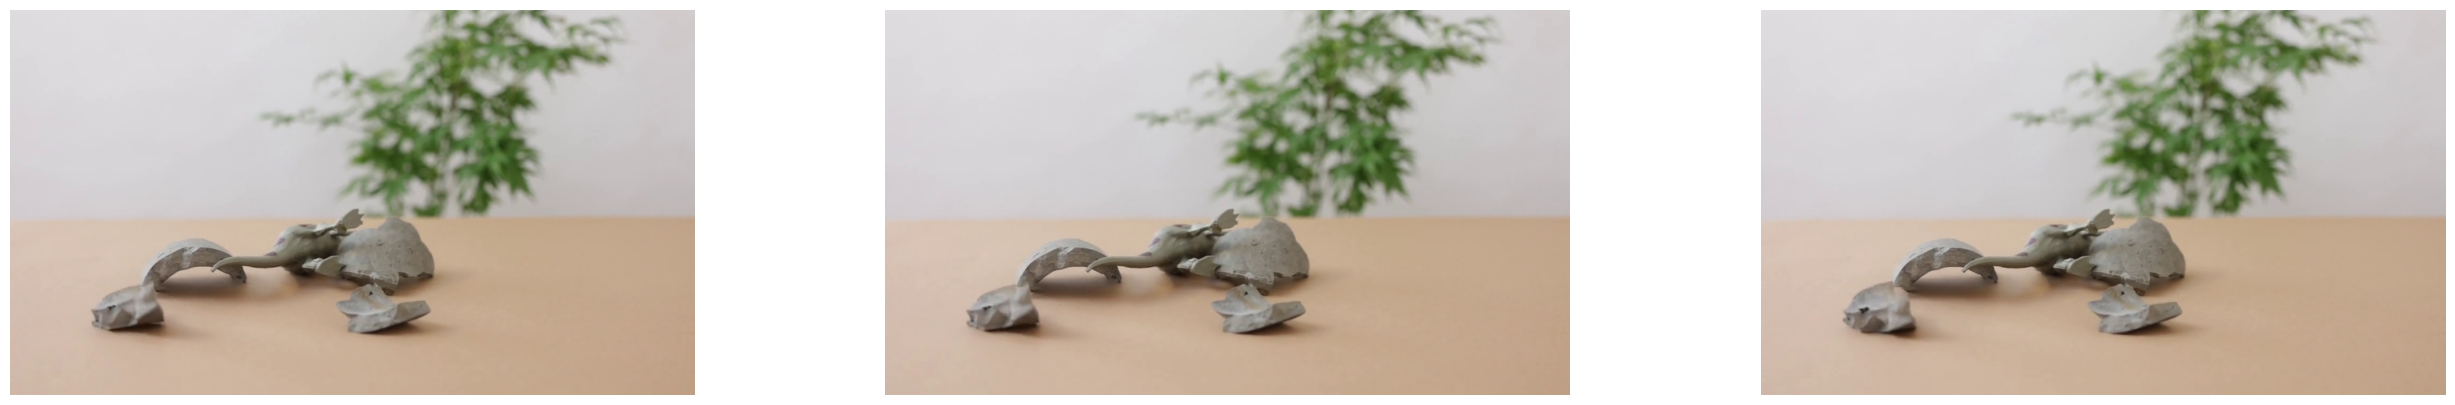

In [70]:
data_loader = ROCALVideoIterator(pipe, multiplier=pipe._multiplier, offset=pipe._offset, display=display, sequence_length=sequence_length)

for i, it in enumerate(data_loader):
    if i == n_iter:
        break
    for sequence in it:
        display_sequence(sequence)
data_loader.reset()